<a href="https://colab.research.google.com/github/deshanchathusanka/abuses-biases-blessing-of-data/blob/main/SIDU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tqdm

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
import os
from pathlib import Path
from matplotlib import pyplot as plt
from skimage.transform import resize
from tqdm import tqdm
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Activation, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions
from tensorflow.python.keras.models import load_model
from keras import backend as K
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial.distance import cdist
from tensorflow.keras import layers,models

from os.path import join, exists

In [ ]:
def load_img(path, input_size):
    """ to load the image for the pretrained model which are trained from imagenet """
    img = image.load_img(path, target_size=input_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [ ]:
def generate_masks_conv_output(input_size, last_conv_output, s= 8):
    """ 
    To generate mask from the last convlutional layers of  CNN model 
    input_size = (224, 224) 
    last_conv_output = (7, 7, 2048)
    """ 
    cell_size = np.ceil(np.array(input_size) / s)  ## [224. 224.]/8 = [28. 28.]
    up_size = (s) * cell_size ## [28. 28.]*8 = [224. 224.]

    grid = np.rollaxis(last_conv_output, 2, 0) ## (2048, 7, 7) = last convolution layer output
    N = len(grid) ## 2048
    masks = np.empty((N, *input_size)) ## (2048, 224, 224) = empty array

    for i in tqdm(range(N), desc='Generating masks'): ## Progress bar
        """extracting the each feature maps of last convlution layer """
        conv_out = last_conv_output[:,:,i] ## (7, 7) Pixel values
        
        """converting last convlayer to binary mask"""
        conv_out = conv_out > 0.1 ## (7, 7) Boolean values
        conv_out = conv_out.astype('float32') ## (7, 7) Binary values
        
        ###############  upsampling the binary mask using bi-linear interpolation (feature activaions masks) ##############
        final_resize = resize(conv_out, up_size, order=1, mode='reflect',
                                anti_aliasing=False) ## conv_out = (7, 7) , up_size = [224. 224.] ## Bilinear Interpolation
        masks[i,:, :] = final_resize  ## (224, 224) matrix with (0 <= value <=1)      
    return masks, grid, cell_size, up_size

In [ ]:
def kernel(d, kernel_width):
    """ 
    computing the exponential weights for the differences
    Input :
        d = (2048, 1000)
        kernel_width = 0.25
    """
    return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2)) ## (2048, 1000)

def sim_differences(pred_org, preds):
    """
    Computing the similarity differences
    Input : 
        pred_org = (1, 1000)
        preds = (2048, 1000)
    """
    diff = abs(pred_org - preds) ## alsolute difference : (2048, 1000)
    similarities = kernel(diff, 0.25) ## gaussian kernel weights : (2048, 1000)
    return similarities, diff


def normalize(array):
      return (array - array.min()) / (array.max() - array.min() + 1e-13)   
  
def uniqness_measure(masks_predictions):
    """ 
    computing the uniqness between the feature maps 
    Input :
        masks_predictions = (2048, 1000)
    """
    distance_filters = cdist(masks_predictions, masks_predictions) ## (2048, 2048) : Euclidient distance
    sum_all_cdist =(distance_filters).sum(axis=1) ## (2048, 1)
    sum_all_cdist = normalize(sum_all_cdist) ## (2048, 1)
    return sum_all_cdist

def explain_SIDU(base_model, input, N, p1, masks, input_size):
    """ 
    SIDU explanation 
    Input :
        masks = (2048, 224, 224, 1)
        input_size = (224, 224)
    """
    preds = []
    batch_size = 100
    # Make sure multiplication is being done for correct axes
    """ generating the feature image mask for the original image using dot product """
    masked = input * masks ## (1, 224, 224, 3)*(2048, 224, 224, 1) = (2048, 224, 224, 3)
    """ predicting the score for oringal _input image """
    
    ####################### prediction of original image #################################
    pred_org = base_model.predict(input) ## (1, 1000)
    """ predicting the scores for all feature image masks """
    
    for i in tqdm(range(0, N, batch_size), desc='Explaining'):
        preds.append(base_model.predict(masked[i:min(i+batch_size, N)]))
        
    ####################### predictions for masked images #################################
    preds = np.concatenate(preds) ## (2048, 1000)
    
    ####################### calculate similarity difference and uniqueness ################
    similerity_measures, diff = sim_differences(pred_org, preds) ## (2048, 1000)
    uniqness_measures = uniqness_measure(preds) ## (2048,)
    uniqness_measures = uniqness_measures.reshape(-1, 1)
    weights = np.multiply(similerity_measures, uniqness_measures) ## (2048, 1000)
    
    sal = weights.T.dot(masks.reshape(N, -1)).reshape(-1, *input_size) ## (1000, 224, 224)
    sal = sal / N / p1
    return sal, weights, similerity_measures, uniqness_measures, pred_org

def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

Explaining: 100%|██████████| 21/21 [00:17<00:00,  1.20it/s]


49152/35363 [=========================================] - 0s 0us/step


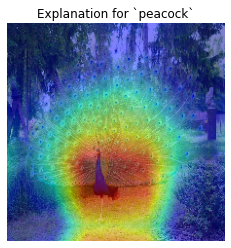

In [ ]:
def predict_and_explain(image_name, model_eval):
  #################### LOADING THE PRE-TRAINED BASE MODEL #############################
  if model_eval == 'Resnet50':
    base_model = ResNet50()
    ####  to see the last layer of CNN use base_model.summary() 
    features_model = Model(inputs=base_model.input, outputs=base_model.get_layer('conv5_block3_out').output)

  elif model_eval == 'Vgg19':
    base_model = VGG19(weights='imagenet')
    features_model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv4').output)
  elif model_eval == 'Vgg16':
    base_model = VGG16(weights='imagenet')
    features_model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv3').output)
  print(features_model.summary())


  ### reading the image from  the folder
  read_path = join('images', image_name)
  img, x = load_img(read_path, (224,224)) # type(img) = Image, type(x) = 4D Tensor = (1, 224, 224, 3) = (1, height, width, channel)
  

  ### extract the last convlution layers' feature activation maps of the model
  feature_activation_maps = features_model.predict(x) # output of the 5th convolutional block = (1, 7, 7, 2048)
  last_conv_output = np.squeeze(feature_activation_maps) # remove unit size dimension(batch size) = (7, 7, 2048)


  masks, grid, cell_size, up_size = generate_masks_conv_output(input_size = (224,224), last_conv_output = last_conv_output, s = 8)
  """
    masks = (2048, 224, 224)
    grid = (2048, 7, 7)
    cell_size = [28. 28.]
    up_size = [224. 224.]
  """
    
  ## TO DISPLAY THE FEATURE ACTIVATION IMAGE MASKS
  masks = np.expand_dims(masks, axis=3) ## (2048, 224, 224, 1) 
  n_masks = len(masks) ## 2048
 
  ### Visual explnations for the object class  
  sal, weights, similerity_measures, uniqness_measures, pred_org = explain_SIDU(base_model, x, n_masks, 0.5, masks, (224,224))

    
  ############### plot original image and heat map ############################
  pred_vec= base_model.predict(x) ## (1, 1000)
  pred = np.argmax(pred_vec)
  class_idx = pred
      
  plt.title('Explanation for `{}`'.format(class_name(class_idx)))
  plt.axis('off')
  ################ plot original image ##################
  plt.imshow(img) 
  ################ plot salience map ###################
  plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
  plt.axis('off') 
  plt.show()




####################### Testing ##############################
image_name = 'peacock.jpg'
selected_model = 'Resnet50' ## CHOOSING THE base MODEL TO GET EXPLANTIONS
predict_and_explain(image_name, selected_model)

**Colormap Used In Salience Map**

jet_color_map.png


**Additional Study**

* Bilinear Interpolation

* ImageNet dataset : 1000 object classes